In [1]:
import os
import settings
import ast
from matplotlib import pyplot as plt

In [2]:
def loadresult(name : str) -> str:
    if name == "main":
        w = ''
    else:
        w = 'w'
    with open(os.path.join(settings.DIR_RESULT, f"log-{w}{name}.txt"), 'r') as f:
        return f.read()

main = loadresult('main')

workers = [loadresult(str(i)).split('\n') for i in range(settings.N_WORKERS)]

In [3]:
def parse_log_worker(logfile : list):
    def parse_summary(summary : str):
        assert summary.startswith("Episode Summary")
        summary = summary[len("Episode Summary") + 1:]
        summary = summary.replace("] [", "],[")
        
        loss, reward = ast.literal_eval(summary)
        return loss, reward

    sep_idx = [idx + 1 for idx, val in enumerate(logfile) if "Allocated on device" in val]
    res = [logfile[i + 1: j - 1] for i, j in zip([0] + sep_idx, sep_idx + ([len(logfile) + 1] if sep_idx[-1] != len(logfile) else []))][1:]
    return [(i, *parse_summary(r[-1])) for i, r in enumerate(res)]

results = [parse_log_worker(w) for w in workers]

In [11]:
# collect statistics
sum_rewards = [[sum(epoch[2]) for epoch in r] for r in results]
loss = [[epoch[1] for epoch in r] for r in results]
rewards = [[epoch[2] for epoch in r] for r in results]
episodes = len(sum_rewards[0])

print("# Episodes", episodes)

# Episodes 364


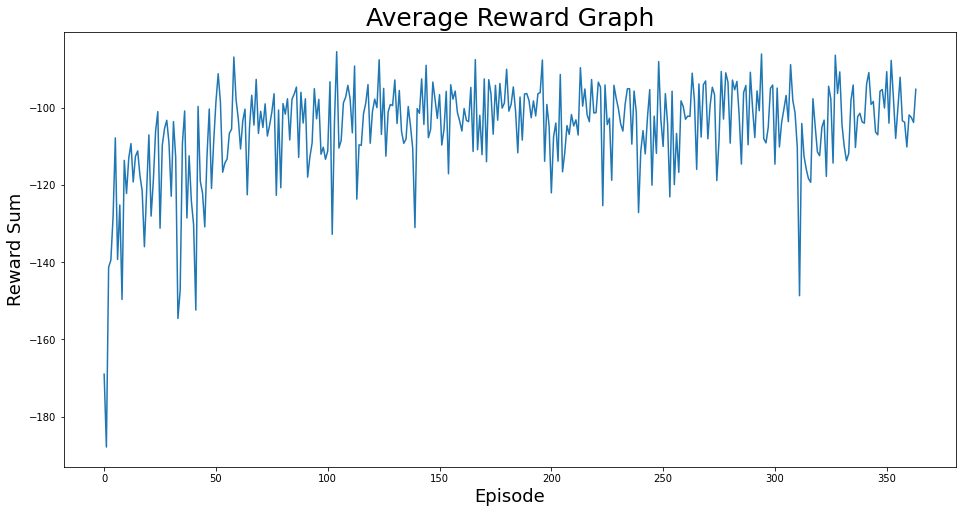

In [5]:
# Average reward of workers during epochs

figure, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Average Reward Graph",fontsize=25)
ax.set_xlabel("Episode",fontsize=18)
ax.set_ylabel("Reward Sum",fontsize=18)
ax.plot([ sum([r[i] for r in sum_rewards]) / len(results) for i in range(len(sum_rewards[0]))])

(0.0, 20.0)

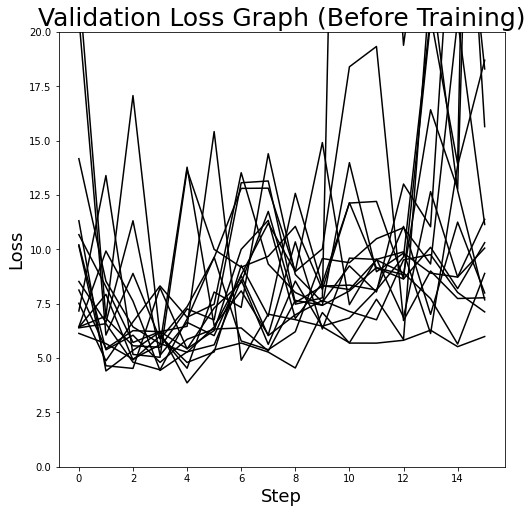

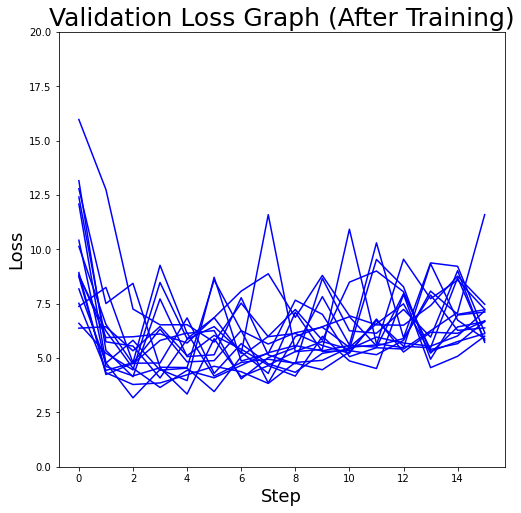

In [9]:
# Validation Loss Comparison

def invert(l : list) -> list:
    return [-i for i in l]

figure, ax = plt.subplots(figsize=(8,8))
figure2, ax2 = plt.subplots(figsize=(8,8))
ax.set_title(f"Validation Loss Graph (Before Training)",fontsize=25)
ax.set_xlabel("Step",fontsize=18)
ax.set_ylabel("Loss",fontsize=18)
ax2.set_title(f"Validation Loss Graph (After Training)",fontsize=25)
ax2.set_xlabel("Step",fontsize=18)
ax2.set_ylabel("Loss",fontsize=18)

for i in range(4):
    ax.plot (invert(rewards[0][i]), color="black")
    ax.plot (invert(rewards[1][i]), color="black")
    ax.plot (invert(rewards[2][i]), color="black")
    ax.plot (invert(rewards[3][i]), color="black")
    ax2.plot(invert(rewards[0][-1-i]), color="blue")
    ax2.plot(invert(rewards[1][-1-i]), color="blue")
    ax2.plot(invert(rewards[2][-1-i]), color="blue")
    ax2.plot(invert(rewards[3][-1-i]), color="blue")

ax.set_ylim([0, 20])

ax2.set_ylim([0, 20])

In [7]:
# Validation Accuracy Comparison (Before, After)

def get_rewards(filename : str) -> list:
    with open(filename, 'r') as f:
        reward_lines = [l.split(" ")[1] for l in f.read().splitlines() if "Reward" in l]
    return list(map(float, reward_lines))

after_accuracy = get_rewards('result_test/log-w0.txt') # tested by main.py with single worker with trained checkpoint
before_accuracy = get_rewards('result_test_before/log-main.txt') # tested by test.py

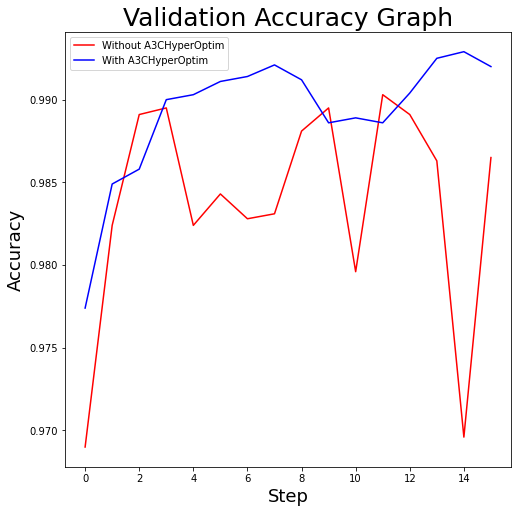

In [8]:
# Plot Validation Accuracy Comparison Graph


figure, ax = plt.subplots(figsize=(8,8))

ax.set_title(f"Validation Accuracy Graph",fontsize=25)
ax.set_xlabel("Step",fontsize=18)
ax.set_ylabel("Accuracy",fontsize=18)


ax.plot(before_accuracy, color="red", label="Without A3CHyperOptim")
ax.plot(after_accuracy, color="blue", label="With A3CHyperOptim")
ax.legend()